In [1]:
import os
import time
import pandas as pd
import numpy as np

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split as surprise_train_test_split
from sklearn.model_selection import train_test_split as sklearn_train_test_split

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

#### load the movielens data 

In [3]:
raw_data = Dataset.load_builtin('ml-100k').build_full_trainset()

In [4]:
df_list_dict = list(raw_data.ur.items())

In [5]:
df = []
for i in range(len(df_list_dict)):
    df_i = np.array(df_list_dict[i][1])
    df_i = np.hstack((np.tile(i, (len(df_i),1)), df_i))
    df.append(df_i)
    
df = pd.DataFrame(np.vstack(df), columns=['uid','mid','rating'])

In [6]:
df_train, df_test = sklearn_train_test_split(df, 
                                             stratify=df['uid'],
                                             test_size=0.1, 
                                             random_state=9408)

In [7]:
df_train, df_valid = sklearn_train_test_split(df_train, 
                                              stratify=df_train['uid'],
                                              test_size=0.1, 
                                              random_state=9408)

In [8]:
print('df_train: {} ratings, {} items, {} users'.format(len(df_train), 
                                                        len(df_train['mid'].unique()),
                                                        len(df_train['uid'].unique())))
print('df_valid: {} ratings, {} items, {} users'.format(len(df_valid), 
                                                        len(df_valid['mid'].unique()),
                                                        len(df_valid['uid'].unique())))
print('df_test: {} ratings, {} items, {} users'.format(len(df_test), 
                                                        len(df_test['mid'].unique()),
                                                        len(df_test['uid'].unique())))

df_train: 81000 ratings, 1654 items, 943 users
df_valid: 9000 ratings, 1215 items, 943 users
df_test: 10000 ratings, 1252 items, 943 users


In [9]:
df_train.to_csv('./data/ml_100k_train_data.csv', index=False)
df_valid.to_csv('./data/ml_100k_valid_data.csv', index=False)
df_test.to_csv('./data/ml_100k_test_data.csv', index=False)

#### preprocessing

In [3]:
df_train = pd.read_csv('./data/ml_100k_train_data.csv')
df_valid = pd.read_csv('./data/ml_100k_valid_data.csv')
df_test = pd.read_csv('./data/ml_100k_test_data.csv')

In [4]:
df_train = df_train.sort_values(by=['uid','mid']).reset_index(drop=True)
df_valid = df_valid.sort_values(by=['uid','mid']).reset_index(drop=True)
df_test = df_test.sort_values(by=['uid','mid']).reset_index(drop=True)

In [5]:
raw_dat_parameters = Dataset.load_builtin('ml-100k').build_full_trainset()

In [6]:
num_users = raw_dat_parameters.n_users
num_movies = raw_dat_parameters.n_items
num_ratings = raw_dat_parameters.n_ratings

In [7]:
num_users

943

In [8]:
raw_dat_parameters.global_mean

3.52986

In [9]:
def preprocessor(df, num_user, num_movie, use_global_avg=True):
    
    # generate sparse matrix
    um_matrix = np.full((num_user, num_movie), 999.0)
    
    for (_, uid, mid, rateid) in df.itertuples():
        um_matrix[int(uid)][int(mid)] = rateid
        
    # generate sparse matrix mask
    um_matrix_mask = np.full((num_user, num_movie), 1.0)
    empty_row, empty_column = np.where(um_matrix == 999.0)
    
    for er, ec in zip(empty_row, empty_column):
        um_matrix_mask[er][ec] = 0
        
        # fill the empty with average or whatever
        if use_global_avg:
            um_matrix[er][ec] = raw_dat_parameters.global_mean
        else:
            um_matrix[er][ec] = 0
            
    return um_matrix, um_matrix_mask

In [10]:
# # Sparse matrix generations
# train_sparse_matrix, train_sparse_matrix_mask = preprocessor(df_train, num_users, num_movies, use_global_avg=True)
# valid_sparse_matrix, valid_sparse_matrix_mask = preprocessor(df_valid, num_users, num_movies, use_global_avg=True)
# test_sparse_matrix, test_sparse_matrix_mask = preprocessor(df_test, num_users, num_movies, use_global_avg=True)

In [11]:
# Sparse matrix generations
train_sparse_matrix, train_sparse_matrix_mask = preprocessor(df_train, num_users, num_movies, use_global_avg=False)
valid_sparse_matrix, valid_sparse_matrix_mask = preprocessor(df_valid, num_users, num_movies, use_global_avg=False)
test_sparse_matrix, test_sparse_matrix_mask = preprocessor(df_test, num_users, num_movies, use_global_avg=False)

In [14]:
train_sparse_matrix.shape

(943, 1682)

In [16]:
valid_sparse_matrix.shape

(943, 1682)

In [15]:
test_sparse_matrix.shape

(943, 1682)

In [12]:
# np.save('./data/train_sparse_matrix.npy', train_sparse_matrix)
# np.save('./data/train_sparse_matrix_mask.npy', train_sparse_matrix_mask)
# np.save('./data/valid_sparse_matrix.npy', valid_sparse_matrix)
# np.save('./data/valid_sparse_matrix_mask.npy', valid_sparse_matrix_mask)
# np.save('./data/test_sparse_matrix.npy', test_sparse_matrix)
# np.save('./data/test_sparse_matrix_mask.npy', test_sparse_matrix_mask)

In [13]:
# np.array(df_train[['uid']])

#### Denoise Autoencoder

In [14]:
import torch
import torch.nn as nn

In [15]:
def plot_grad_flow(named_parameters, batch_id, whichone='D'):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            
    plt.plot(ave_grads, alpha=0.5, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=-.2, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
#     plt.ylim(ymin=-0.02, ymax=1)
    plt.title("{} Gradient flow batch {}".format(whichone, batch_id))
    plt.grid(True)
    plt.show()

In [16]:
def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

In [17]:
def normal_init(m, mean, std):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, mean, std)
        nn.init.constant_(m.bias.data, 0.0)

In [76]:
class DAutoencoder(nn.Module):
    def __init__(self, code_depth=64):
        super(DAutoencoder, self).__init__()
        
        self.encoder_fc1 = nn.Linear(num_movies, code_depth*2)
        self.encoder_fc2 = nn.Linear(code_depth*2, code_depth)
        self.decoder_fc1 = nn.Linear(code_depth, code_depth*2)
        self.decoder_fc2 = nn.Linear(code_depth*2, num_movies)
        self.activation = nn.Sigmoid()
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, x):
        x = self.activation(self.encoder_fc1(x))
        x = self.activation(self.encoder_fc2(x))
        x = self.activation(self.decoder_fc1(x))
        x = self.decoder_fc2(x)
        return x

In [77]:
print_network(DAutoencoder())

DAutoencoder(
  (encoder_fc1): Linear(in_features=1682, out_features=128, bias=True)
  (encoder_fc2): Linear(in_features=128, out_features=64, bias=True)
  (decoder_fc1): Linear(in_features=64, out_features=128, bias=True)
  (decoder_fc2): Linear(in_features=128, out_features=1682, bias=True)
  (activation): Sigmoid()
)
Total number of parameters: 448978


#### Train

In [78]:
train_sparse_matrix.shape

(943, 1682)

In [79]:
# train_sparse_matrix = train_sparse_matrix/5
# valid_sparse_matrix = valid_sparse_matrix/5
# test_sparse_matrix = test_sparse_matrix/5

In [100]:
# setup the root 
root = './DAE_Recommender_system/'
if not os.path.isdir(root):
    os.mkdir(root)
    
result_root = os.path.join(root, 'results/')
if not os.path.isdir(result_root):
    os.mkdir(result_root)

In [104]:
num_epoch = 200
learning_rate = 0.0001
noise_factor = 0.1

In [105]:
DAE = DAutoencoder().cuda()

In [106]:
BCE_loss = nn.BCELoss().cuda()
MSE_loss = nn.MSELoss().cuda()

In [107]:
optimizer = torch.optim.Adam(DAE.parameters(), lr=learning_rate)

In [108]:
DAE.weight_init(mean=0.0, std=0.02)

In [109]:
train_loss_hist = []
valid_loss_hist = []
test_loss_hist = []

total_train_input_noisy = []
total_train_output = []
total_valid_input_noisy = []
total_valid_output = []
total_test_input_noisy = []
total_test_output = []

for epoch in range(1, num_epoch + 1):
    
    epoch_start_time = time.time()
    
    #---------------- training -----------------#
    train_loss = 0.0
    train_input_noisy = []
    train_output = []
    
    for u in range(num_users):
        
        optimizer.zero_grad()
        
        x_input = torch.Tensor(train_sparse_matrix[u]).unsqueeze(0).cuda()
        # add random noise
        x_input_noisy = x_input + noise_factor * torch.randn(len(x_input)).unsqueeze(0).cuda()
        x_input_noisy = torch.clamp(x_input_noisy, 0, 5).cuda()
        # forward
        x_output = DAE(x_input_noisy)
        # no rating at all, skip
        x_output = x_output * torch.Tensor(train_sparse_matrix_mask[u]).unsqueeze(0).cuda()
        # loss MSE
        loss = torch.sqrt(torch.sum((x_output - x_input_noisy)**2)/train_sparse_matrix_mask[u].sum())
#         loss = MSE_loss(x_output, x_input)
        # backpropagation
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        train_input_noisy.append(x_input_noisy.detach().cpu().numpy())
        train_output.append(x_output.detach().cpu().numpy())
        
    total_train_input_noisy.append(np.vstack(train_input_noisy))
    total_train_output.append(np.vstack(train_output))

    train_loss_hist.append(train_loss)
    avg_train_loss = train_loss/num_users
    
    #---------------- validation -----------------#
    valid_loss = 0.0
    valid_input_noisy = []
    valid_output = []
    
    for v in range(num_users):
        
        # get the prediction 
        x_predict = torch.Tensor(train_sparse_matrix[v]).unsqueeze(0).cuda()
        x_predict_noisy = x_predict + noise_factor * torch.randn(len(x_predict)).unsqueeze(0).cuda()
        x_predict_noisy = torch.clamp(x_predict_noisy, 0, 5).cuda()
        # forward
        x_predict = DAE(x_predict_noisy) 
        # no rating at all, skip
        x_predict = x_predict * torch.Tensor(valid_sparse_matrix_mask[v]).unsqueeze(0).cuda()
        # get the validation 
        x_target = torch.Tensor(valid_sparse_matrix[v]).unsqueeze(0).cuda()
        
        # RMSE loss validation
        loss_validation = torch.sqrt(torch.sum((x_predict - x_target)**2)/valid_sparse_matrix_mask[v].sum())
        
        valid_loss += loss_validation.item()
        
        valid_input_noisy.append(x_predict.detach().cpu().numpy())
        valid_output.append(x_target.detach().cpu().numpy())
        
    total_valid_input_noisy.append(np.vstack(valid_input_noisy))
    total_valid_output.append(np.vstack(valid_output))
        
    valid_loss_hist.append(valid_loss)
    avg_valid_loss = valid_loss/num_users
    
    #---------------- testing -----------------#
    test_loss = 0.0
    test_input_noisy = []
    test_output = []
    
    for t in range(num_users):
        
        # get the prediction 
        x_predict_test = torch.Tensor(train_sparse_matrix[t]).unsqueeze(0).cuda()
        x_predict_noisy_test = x_predict_test + noise_factor * torch.randn(len(x_predict_test)).unsqueeze(0).cuda()
        x_predict_noisy_test = torch.clamp(x_predict_noisy_test, 0, 5).cuda()
        # forward
        x_predict_test = DAE(x_predict_noisy_test) 
        # no rating at all, skip
        x_predict_test = x_predict_test * torch.Tensor(test_sparse_matrix_mask[t]).unsqueeze(0).cuda()
        # get the test 
        x_target_test = torch.Tensor(test_sparse_matrix[t]).unsqueeze(0).cuda()
        
        # RMSE loss testation
        loss_test = torch.sqrt(torch.sum((x_predict_test - x_target_test)**2)/test_sparse_matrix_mask[t].sum())
        
        test_loss += loss_test.item()
        
        test_input_noisy.append(x_predict_test.detach().cpu().numpy())
        test_output.append(x_target_test.detach().cpu().numpy())
        
    total_test_input_noisy.append(np.vstack(test_input_noisy))
    total_test_output.append(np.vstack(test_output))
        
    test_loss_hist.append(test_loss)
    avg_test_loss = test_loss/num_users
    
    print("[Epoch %d/%d] Train loss:[loss: %f] | Valid loss: [loss: %f] | Test loss: [loss: %f]" 
          % (epoch, (num_epoch+1), avg_train_loss**2, avg_valid_loss**2, avg_test_loss**2))
    
    epoch_end_time = time.time()
    print('time used: {}'.format(epoch_end_time - epoch_start_time))
    
    if avg_valid_loss<0.05:
        print("early stop")
        break
        
#     plot_grad_flow(DAE.named_parameters(), epoch, 'DAE')
    
total_train_input_noisy = np.array(total_train_input_noisy)
total_train_output = np.array(total_train_output)

total_valid_input_noisy = np.array(total_valid_input_noisy)
total_valid_output = np.array(total_valid_output)

total_test_input_noisy = np.array(total_test_input_noisy)
total_test_output = np.array(total_test_output)

train_loss_hist = np.array(train_loss_hist)
valid_loss_hist = np.array(valid_loss_hist)
test_loss_hist = np.array(test_loss_hist)
    

[Epoch 1/201] Train loss:[loss: 5.213200] | Valid loss: [loss: 1.602133] | Test loss: [loss: 1.711031]
time used: 8.565194368362427
[Epoch 2/201] Train loss:[loss: 1.503847] | Valid loss: [loss: 1.050975] | Test loss: [loss: 1.120700]
time used: 8.50837254524231
[Epoch 3/201] Train loss:[loss: 1.265976] | Valid loss: [loss: 0.983441] | Test loss: [loss: 1.041708]
time used: 7.88899302482605
[Epoch 4/201] Train loss:[loss: 1.220486] | Valid loss: [loss: 0.965810] | Test loss: [loss: 1.015667]
time used: 7.770338773727417
[Epoch 5/201] Train loss:[loss: 1.203421] | Valid loss: [loss: 0.960130] | Test loss: [loss: 1.005691]
time used: 7.79626727104187
[Epoch 6/201] Train loss:[loss: 1.162815] | Valid loss: [loss: 0.953078] | Test loss: [loss: 0.998916]
time used: 7.751360893249512
[Epoch 7/201] Train loss:[loss: 1.156538] | Valid loss: [loss: 0.951628] | Test loss: [loss: 0.996435]
time used: 7.749334096908569
[Epoch 8/201] Train loss:[loss: 1.168463] | Valid loss: [loss: 0.948997] | Test

[Epoch 123/201] Train loss:[loss: 0.951597] | Valid loss: [loss: 0.817818] | Test loss: [loss: 0.850280]
time used: 7.770305156707764
[Epoch 124/201] Train loss:[loss: 0.958444] | Valid loss: [loss: 0.819749] | Test loss: [loss: 0.846841]
time used: 7.768337249755859
[Epoch 125/201] Train loss:[loss: 0.932637] | Valid loss: [loss: 0.819341] | Test loss: [loss: 0.847792]
time used: 7.774267911911011
[Epoch 126/201] Train loss:[loss: 0.936877] | Valid loss: [loss: 0.814205] | Test loss: [loss: 0.848076]
time used: 7.75637149810791
[Epoch 127/201] Train loss:[loss: 0.948202] | Valid loss: [loss: 0.812662] | Test loss: [loss: 0.846158]
time used: 7.750326156616211
[Epoch 128/201] Train loss:[loss: 0.947923] | Valid loss: [loss: 0.811751] | Test loss: [loss: 0.846090]
time used: 7.761356830596924
[Epoch 129/201] Train loss:[loss: 0.925457] | Valid loss: [loss: 0.807925] | Test loss: [loss: 0.838797]
time used: 7.7662882804870605
[Epoch 130/201] Train loss:[loss: 0.918803] | Valid loss: [los

In [298]:
np.save('./result/total_train_input_noisy.npy', total_train_input_noisy)
np.save('./result/total_train_output.npy', total_train_output)
np.save('./result/total_valid_input_noisy.npy', total_valid_input_noisy)
np.save('./result/total_valid_output.npy', total_valid_output)
np.save('./result/total_test_input_noisy.npy', total_test_input_noisy)
np.save('./result/total_test_output.npy', total_test_output)

np.save('./result/train_loss_hist.npy', train_loss_hist)
np.save('./result/valid_loss_hist.npy', valid_loss_hist)
np.save('./result/test_loss_hist.npy', test_loss_hist)

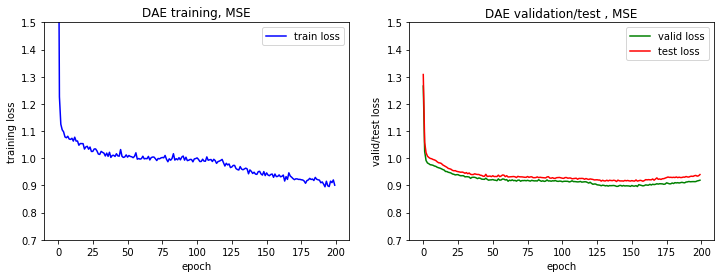

In [305]:
# loss visualization
fig2, axs2 = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs2[0].plot(train_loss_hist/943, 'b', label='train loss')
axs2[1].plot(valid_loss_hist/943, 'g', label='valid loss')
axs2[1].plot(test_loss_hist/943, 'r', label='test loss')

axs2[0].set_title('DAE training, MSE')
axs2[1].set_title('DAE validation/test , MSE')
axs2[0].set_ylim(0.7,1.5)
axs2[1].set_ylim(0.7,1.5)
axs2[0].set_ylabel('training loss')
axs2[1].set_ylabel('valid/test loss')

axs2[0].set_xlabel('epoch')
axs2[1].set_xlabel('epoch')

axs2[0].legend()
axs2[1].legend()
plt.show()

fig2.savefig('./result/MSE_loss.png', bbox_inches = 'tight')


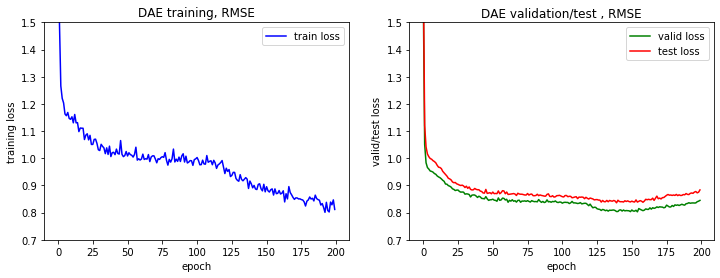

In [306]:
# loss visualization
fig2, axs2 = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs2[0].plot((train_loss_hist/943)**2, 'b', label='train loss')
axs2[1].plot((valid_loss_hist/943)**2, 'g', label='valid loss')
axs2[1].plot((test_loss_hist/943)**2, 'r', label='test loss')

axs2[0].set_title('DAE training, RMSE')
axs2[1].set_title('DAE validation/test , RMSE')
axs2[0].set_ylim(0.7,1.5)
axs2[1].set_ylim(0.7,1.5)
axs2[0].set_ylabel('training loss')
axs2[1].set_ylabel('valid/test loss')

axs2[0].set_xlabel('epoch')
axs2[1].set_xlabel('epoch')

axs2[0].legend()
axs2[1].legend()
plt.show()

fig2.savefig('./result/RMSE_loss.png', bbox_inches = 'tight')


In [349]:
check_epoch = 150
check_pred_length = 1600
check_pred_user = 20

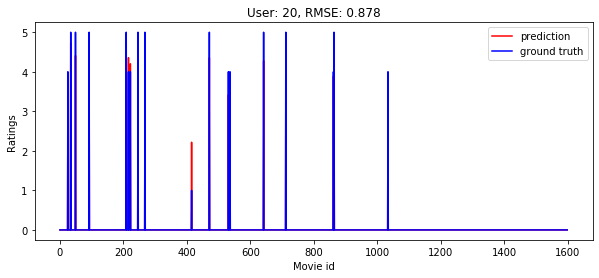

In [350]:
prediction_check = total_test_input_noisy[check_epoch][:check_pred_length,:check_pred_length][check_pred_user]
groud_truth_check = total_test_output[check_epoch][:check_pred_length,:check_pred_length][check_pred_user]
RMSE = np.sqrt(sum((groud_truth_check - prediction_check)**2)/len(groud_truth_check[groud_truth_check != 0]))

fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axs2.plot(prediction_check, c='r', label='prediction')
axs2.plot(groud_truth_check, c='b', label='ground truth')
axs2.set_title('User: {}, RMSE: {}'.format(check_pred_user, round(RMSE,3)))
axs2.set_xlabel('Movie id')
axs2.set_ylabel('Ratings')
axs2.legend()
plt.show()

fig2.savefig('./result/sample_prediction_performance.png', bbox_inches = 'tight')

In [355]:
check_epoch = 100
check_pred_length = 50

In [356]:
prediction_check_heatmap = total_test_input_noisy[check_epoch][:check_pred_length,:check_pred_length]
groud_truth_check_heatmap = total_test_output[check_epoch][:check_pred_length,:check_pred_length]

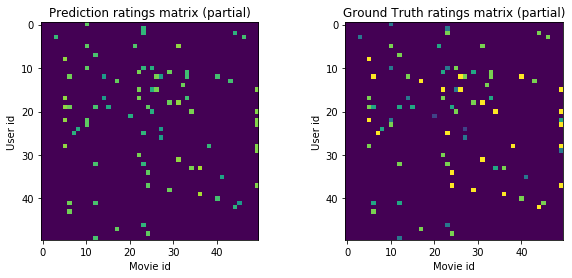

In [354]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs[0].imshow(prediction_check_heatmap, vmin=0, vmax=5)
axs[1].imshow(groud_truth_check_heatmap, vmin=0, vmax=5)
axs[0].set_title('Prediction ratings matrix (partial)')
axs[1].set_title('Ground Truth ratings matrix (partial)')
axs[0].set_xlabel('Movie id')
axs[0].set_ylabel('User id')
axs[1].set_xlabel('Movie id')
axs[1].set_ylabel('User id')
plt.show()

fig.savefig('./result/sample_prediction_performance_heatmap_epoch1.png', bbox_inches = 'tight')

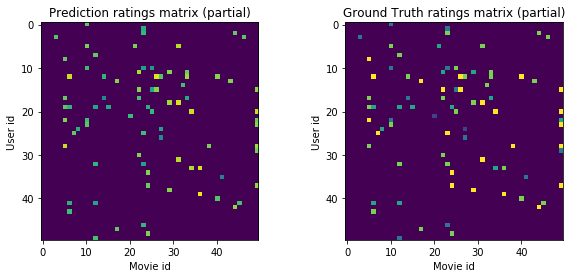

In [357]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs[0].imshow(prediction_check_heatmap, vmin=0, vmax=5)
axs[1].imshow(groud_truth_check_heatmap, vmin=0, vmax=5)
axs[0].set_title('Prediction ratings matrix (partial)')
axs[1].set_title('Ground Truth ratings matrix (partial)')
axs[0].set_xlabel('Movie id')
axs[0].set_ylabel('User id')
axs[1].set_xlabel('Movie id')
axs[1].set_ylabel('User id')
plt.show()

fig.savefig('./result/sample_prediction_performance_heatmap_epoch100.png', bbox_inches = 'tight')

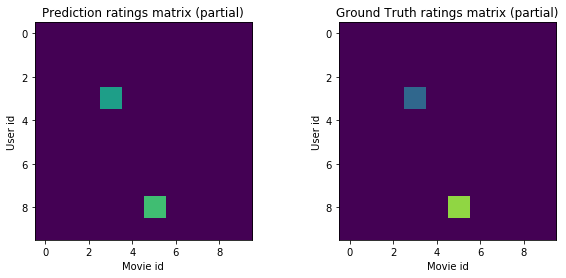

In [286]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs[0].imshow(prediction_check_heatmap, vmin=0, vmax=6)
axs[1].imshow(groud_truth_check_heatmap, vmin=0, vmax=6)
axs[0].set_title('Prediction ratings matrix (partial)')
axs[1].set_title('Ground Truth ratings matrix (partial)')
axs[0].set_xlabel('Movie id')
axs[0].set_ylabel('User id')
axs[1].set_xlabel('Movie id')
axs[1].set_ylabel('User id')
plt.show()